# PROBLEM: Recommender Systems
In this homework, you are asked to implement four different recommendation methods without
using any recommendation packages. Specifically, you need to implement **User‐based Collaborative
Filtering**, **Item‐based Collaborative Filtering**, **Hybrid Method**, and **Latent Factor Model (Matrix
Factorization)** without and with regularization, global mean, user bias, and item bias. Then your tasks
are to compare the performance of these typical recommendation methods with different settings.

In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import scipy.stats
import scipy.spatial
import math
from math import sqrt

### First, convert the rating file into a user-item matrix

In [2]:
ratingfile = 'ratings.data'
header = ['user_id','item_id','rating','timestamp']
df = pd.read_csv(ratingfile, sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = '+str(n_users)+' | Number of movies = '+str(n_items))

user_item_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    user_item_matrix[line[1]-1,line[2]-1]=line[3]

Number of users = 943 | Number of movies = 1682


In [3]:
# split the data set into training set and testing set
train_data, test_data = train_test_split(df, test_size=0.25)

# (1)User‐based Collaborative Filtering (U‐CF)
In user‐based CF, your task is to use Cosine (cos) and Pearson Correlation Coefficient (pcc) as two
different similarity metrics to compute the similarity between users and find the top‐𝐾 similar users.
So there are two methods, U‐CF‐cos and U‐CF‐pcc.

In [4]:
def cosine_sim(u,v):
    c1=np.dot(u,v)
    c2=LA.norm(u)*LA.norm(v)
    if c2==0:
        r=0
    else:
        r=c1/c2
    return r

## Pre-compute the user-user similarity matrix using cosine similarity measure
The user-user similarity matrix represents the similiarty between each user-user pair. 

In [5]:
user_similarity_cosine=np.zeros(user_item_matrix.shape[0])
for user_be_chosen in range(user_item_matrix.shape[0]):
    r=[]
    for other_users in range(user_item_matrix.shape[0]):
        r.append(cosine_sim(user_item_matrix[user_be_chosen,:],user_item_matrix[other_users,:]))
    user_similarity_cosine=np.c_[user_similarity_cosine,r]
user_similarity_cosine=user_similarity_cosine[:,1:]
user_similarity_cosine

array([[ 1.        ,  0.16693098,  0.04745954, ...,  0.14861694,
         0.17950788,  0.39817474],
       [ 0.16693098,  1.        ,  0.11059132, ...,  0.16148478,
         0.17226781,  0.10579788],
       [ 0.04745954,  0.11059132,  1.        , ...,  0.10124256,
         0.13341615,  0.02655587],
       ..., 
       [ 0.14861694,  0.16148478,  0.10124256, ...,  1.        ,
         0.1016418 ,  0.09511958],
       [ 0.17950788,  0.17226781,  0.13341615, ...,  0.1016418 ,
         1.        ,  0.18246466],
       [ 0.39817474,  0.10579788,  0.02655587, ...,  0.09511958,
         0.18246466,  1.        ]])

## Pre-compute the user-user similarity matrix using pearson correlation
The user-user similarity matrix represents the similiarty between each user-user pair.

In [6]:
user_similarity_pcc=np.zeros(user_item_matrix.shape[0])
for user_be_chosen in range(user_item_matrix.shape[0]):
    r=[]
    for other_users in range(user_item_matrix.shape[0]):
        r.append(scipy.stats.pearsonr(user_item_matrix[user_be_chosen,:],user_item_matrix[other_users,:])[0])
    user_similarity_pcc=np.c_[user_similarity_pcc,r]
user_similarity_pcc=user_similarity_pcc[:,1:]
user_similarity_pcc

array([[ 1.        ,  0.10632193, -0.01642393, ...,  0.1155035 ,
         0.10898367,  0.32323078],
       [ 0.10632193,  1.        ,  0.08268017, ...,  0.14417664,
         0.13829245,  0.05423526],
       [-0.01642393,  0.08268017,  1.        , ...,  0.08453195,
         0.10202478, -0.02360053],
       ..., 
       [ 0.1155035 ,  0.14417664,  0.08453195, ...,  1.        ,
         0.08012962,  0.06529963],
       [ 0.10898367,  0.13829245,  0.10202478, ...,  0.08012962,
         1.        ,  0.12773543],
       [ 0.32323078,  0.05423526, -0.02360053, ...,  0.06529963,
         0.12773543,  1.        ]])

## Rating predict function based on the the user-user similarity
Present the performance in terms of RMSE with user‐based CF.

In [7]:
def userbased_predict_rmse(train,test,user_similarity,n_users,n_items,k):
    print("Compute User-based CF RMSE .......", "K =", k)
    
    train_df=pd.DataFrame(train)
    test_df=pd.DataFrame(test)
    
    train_matrix=np.zeros((n_users, n_items))
    for line in train_df.itertuples():
        train_matrix[int(line[1])-1,int(line[2])-1]=line[3]
        
    true_rate,pred_rate=[],[]
        
    for line in test_df.itertuples():
        user=int(line[1])
        item=int(line[2])
        true_rate.append(line[3])
        
        item_pred=3
        
        if np.count_nonzero(train_matrix[user-1]):
            sim=user_similarity[user-1]
            #sort the similarities in descending order, find the k similar items which has the largest similarities
            sorted_index=np.argsort(-sim)
            sum_pearson=0
            dot=0
            
            for i in range(k):
                ind=sorted_index[i]
                # normalize the similarity for the rated items
                sum_pearson+=sim[ind]
                # similarity multiply the ratings
                dot+=sim[ind]*train_matrix[user-1][ind]

            if sum_pearson>0:
                item_pred=dot/sum_pearson
                
        if item_pred<0:
            item_pred=0

        if item_pred>5:
            item_pred=5

        pred_rate.append(item_pred)

    rmse=sqrt(mean_squared_error(true_rate,pred_rate))

    return rmse,pred_rate


# (2)Item‐based Collaborative Filtering (I‐CF)
In item‐based CF, your task is again to use Cosine (cos) and Pearson Correlation Coefficient (pcc) as
two different similarity metrics to compute the similarity between users and find the top‐𝐾 similar
items. So there are two methods, I‐CF‐cos and I‐CF‐pcc.

## Pre-compute the item-item similarity matrix using cosine similarity measure
The item-item similarity matrix represents the similiarty between each item-item pair.

In [8]:
item_similarity_cosine=np.zeros(user_item_matrix.shape[1])

for item_be_chosen in range(user_item_matrix.shape[1]):
    r=[]
    
    for other_items in range(user_item_matrix.shape[1]):
        r.append(cosine_sim(user_item_matrix[:,item_be_chosen],user_item_matrix[:,other_items]))
        
    item_similarity_cosine=np.c_[item_similarity_cosine,r]
    
item_similarity_cosine=item_similarity_cosine[:,1:]
item_similarity_cosine

array([[ 1.        ,  0.40238218,  0.33024479, ...,  0.        ,
         0.04718307,  0.04718307],
       [ 0.40238218,  1.        ,  0.27306918, ...,  0.        ,
         0.07829936,  0.07829936],
       [ 0.33024479,  0.27306918,  1.        , ...,  0.        ,
         0.        ,  0.09687505],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.04718307,  0.07829936,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.04718307,  0.07829936,  0.09687505, ...,  0.        ,
         0.        ,  1.        ]])

## Pre-compute the item-item similarity matrix using pearson correlation
The item-item similarity matrix represents the similiarty between each item-item pair.

In [9]:
item_similarity_pcc=np.zeros(user_item_matrix.shape[1])

for item_be_chosen in range(user_item_matrix.shape[1]):
    r=[]
    
    for other_items in range(user_item_matrix.shape[1]):
        r.append(scipy.stats.pearsonr(user_item_matrix[:,item_be_chosen],user_item_matrix[:,other_items])[0])
        
    item_similarity_pcc=np.c_[item_similarity_pcc,r]
    
item_similarity_pcc=item_similarity_pcc[:,1:]
item_similarity_pcc

array([[ 1.        ,  0.23459453,  0.19336208, ..., -0.02967574,
         0.03417873,  0.03417873],
       [ 0.23459453,  1.        ,  0.1906486 , ..., -0.01245099,
         0.07141535,  0.07141535],
       [ 0.19336208,  0.1906486 ,  1.        , ..., -0.00976446,
        -0.00976446,  0.09142113],
       ..., 
       [-0.02967574, -0.01245099, -0.00976446, ...,  1.        ,
        -0.00106157, -0.00106157],
       [ 0.03417873,  0.07141535, -0.00976446, ..., -0.00106157,
         1.        , -0.00106157],
       [ 0.03417873,  0.07141535,  0.09142113, ..., -0.00106157,
        -0.00106157,  1.        ]])

## Rating predict function based on the the item-item similarity
Present the performance in terms of RMSE with item‐based CF.

In [10]:
def itembased_predict_rmse(train,test,item_similarity,n_users,n_items,k):
    print("Compute Item-based CF RMSE .......", "K =", k)
    
    train_df=pd.DataFrame(train)
    test_df=pd.DataFrame(test)
    
    train_matrix=np.zeros((n_users, n_items))
    for line in train_df.itertuples():
        train_matrix[int(line[1])-1,int(line[2])-1]=line[3]
        
    true_rate,pred_rate=[],[]
        
    for line in test_df.itertuples():
        user=int(line[1])
        item=int(line[2])
        true_rate.append(line[3])
        
        item_pred=3
        
        if np.count_nonzero(train_matrix[:,item-1]):
            sim=item_similarity[item-1]
            #sort the similarities in descending order, find the k similar items which has the largest similarities
            sorted_index=np.argsort(-sim)
            sum_pearson=0
            dot=0
            
            for i in range(k):
                ind=sorted_index[i]
                # normalize the similarity for the rated items
                sum_pearson+=sim[ind]
                # similarity multiply the ratings
                dot+=sim[ind]*train_matrix[user-1][ind]

            if sum_pearson>0:
                item_pred=dot/sum_pearson
                
        if item_pred<0:
            item_pred=0

        if item_pred>5:
            item_pred=5

        pred_rate.append(item_pred)

    rmse=sqrt(mean_squared_error(true_rate,pred_rate))

    return rmse,pred_rate


# Report the Performance for (1) and (2)
Your task is also to present the performance in terms of RMSE, in addition to the implementation
of different collaborative filtering methods. By varying the value 𝐾 = 3, 4, 5,6,7,8,9,10,20,30,40,50,
60,70,80,90,100 as the x‐axis, and putting the RMSE values in the y‐axis, we can evaluate and
compare how different CF methods perform in the testing user‐movie pairs. You should show the
results by plotting a figure.

In [11]:
rmse_user_cos = []
rmse_user_pcc = []
rmse_item_cos = []
rmse_item_pcc = []
k_sim = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
for i in k_sim:
    k=i
    # user-based CF
    rmse_u_cos, pred_rate_u_cos = userbased_predict_rmse(train_data, test_data, user_similarity_cosine , n_users, n_items, k)
    rmse_u_pcc, pred_rate_u_pcc = userbased_predict_rmse(train_data, test_data, user_similarity_pcc, n_users, n_items, k)
    rmse_user_cos.append(rmse_u_cos)
    rmse_user_pcc.append(rmse_u_pcc)
    # item-based CF
    rmse_i_cos,pred_rate_i_cos = itembased_predict_rmse(train_data, test_data, item_similarity_cosine , n_users, n_items, k)
    rmse_i_pcc,pred_rate_i_pcc = itembased_predict_rmse(train_data, test_data, item_similarity_pcc, n_users, n_items, k)
    rmse_item_cos.append(rmse_i_cos) 
    rmse_item_pcc.append(rmse_i_pcc)

Compute User-based CF RMSE ....... K = 3
Compute User-based CF RMSE ....... K = 3
Compute Item-based CF RMSE ....... K = 3
Compute Item-based CF RMSE ....... K = 3
Compute User-based CF RMSE ....... K = 4
Compute User-based CF RMSE ....... K = 4
Compute Item-based CF RMSE ....... K = 4
Compute Item-based CF RMSE ....... K = 4
Compute User-based CF RMSE ....... K = 5
Compute User-based CF RMSE ....... K = 5
Compute Item-based CF RMSE ....... K = 5
Compute Item-based CF RMSE ....... K = 5
Compute User-based CF RMSE ....... K = 6
Compute User-based CF RMSE ....... K = 6
Compute Item-based CF RMSE ....... K = 6
Compute Item-based CF RMSE ....... K = 6
Compute User-based CF RMSE ....... K = 7
Compute User-based CF RMSE ....... K = 7
Compute Item-based CF RMSE ....... K = 7
Compute Item-based CF RMSE ....... K = 7
Compute User-based CF RMSE ....... K = 8
Compute User-based CF RMSE ....... K = 8
Compute Item-based CF RMSE ....... K = 8
Compute Item-based CF RMSE ....... K = 8
Compute User-bas

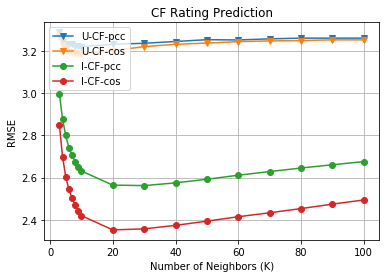

In [12]:
idx = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
plt.plot(idx, rmse_user_pcc, marker='v', label='U-CF-pcc')
plt.plot(idx, rmse_user_cos,marker='v',  label='U‐CF‐cos')
plt.plot(idx, rmse_item_pcc, marker='o', label='I-CF-pcc')
plt.plot(idx, rmse_item_cos,marker='o',  label='I‐CF‐cos')
plt.title('CF Rating Prediction')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# (3) Latent Factor Model (Matrix Factorization)
Your last task is to implement the latent factor model, i.e., Matrix Factorization (MF), to predict
user‐movie ratings. Assume there are 𝑚 users and 𝑛 items. Given the rating matrix 𝑅 (𝑚 x
𝑛) constructed from the training data, along with missing and testing ratings in 𝑅, your goal is to
find the user latent matrix 𝑃 (𝑚 x k) and the item latent matrix 𝑄 (𝑛 x k), where 𝑘 is the number
of latent features/factors, such that 𝑅 can be approximated: 𝑅 ~ P^T * Q .

## Split the user-item matrix set into training set and testing set

In [13]:
def transfer_matrix(df):
    ini=np.zeros((943,1682))
    for line in df.itertuples():
        item_id=line[2]
        user_id=line[1]
        rating=line[3]
        ini[user_id-1,item_id-1]=rating
    return ini

train_matrix=transfer_matrix(train_data)
test_matrix=transfer_matrix(test_data)
train_matrix,test_matrix

(array([[ 5.,  3.,  0., ...,  0.,  0.,  0.],
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 5.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  4., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  5.,  0., ...,  0.,  0.,  0.]]))

## Get the index for the non-zero rating in training and testing user-item matrix 

In [14]:
# Index matrix for training data
train_ind=train_matrix.copy()
train_ind[train_ind>0]=1
train_ind[train_ind==0]=0
print(train_ind)

# Index matrix for test data
test_ind=test_matrix.copy()
test_ind[test_ind>0]=1
test_ind[test_ind==0]=0
print(test_ind)

[[ 1.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]


## Rooted mean square error computation function

In [15]:
def sgd_rmse(ind_matrix,data_matrix,P,Q):
    return np.sqrt(np.sum((ind_matrix*(data_matrix-np.dot(P,Q.T)))**2)/len(data_matrix[data_matrix>0]))

## Stochastic Gradient Descent (SGD) function

In [16]:
def Stochastic_Gradient_Descent(train_m,test_m,factor_k,alpha,lmbda,iteration):
    print("Computing using SGD ......")
    
    ini_user_P_matrix=3*np.random.rand(train_m.shape[0], factor_k)
    ini_item_Q_matrix=3*np.random.rand(train_m.shape[1], factor_k)
    
    train_errors=[]
    test_errors=[]
    
    users,items=train_m.nonzero()
    for it in range(iteration):
        print("SGD Iteration",it+1)
        for u,i in zip(users,items):
            error=train_m[u, i]-(np.dot(ini_user_P_matrix[u],ini_item_Q_matrix[i].T)) 
            ini_user_P_matrix[u]+=alpha*(error*ini_item_Q_matrix[i]-lmbda*ini_user_P_matrix[u]) 
            ini_item_Q_matrix[i]+=alpha*(error*ini_user_P_matrix[u]-lmbda*ini_item_Q_matrix[i])
            
        train_rmse=sgd_rmse(train_ind,train_m,ini_user_P_matrix,ini_item_Q_matrix)  
        test_rmse=sgd_rmse(test_ind,test_m,ini_user_P_matrix,ini_item_Q_matrix) 
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
    return ini_user_P_matrix,ini_item_Q_matrix,train_errors,test_errors

In [17]:
sgd_p,sgd_q,train_errors_list,test_errors_list=Stochastic_Gradient_Descent(train_matrix,test_matrix,20,0.01,0.1,100)

Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration

## Prediction function

In [18]:
def prediction_sgd_bias(P, Q, b_global, b_user, b_item):
    ratings = np.dot(P, Q.T)
    for u in range(len(b_user)):
        for i in range(len(b_item)):
            ratings[u][i] = b_global+b_user[u]+b_item[i]+ratings[u][i]
    return ratings

## Rooted mean square error computation function
Calculate the RMSE for SGD with bias

In [19]:
def sgd_bias_rmse(ind, data_matrix, P, Q, b_global, b_user, b_item):
    return np.sqrt(np.sum((ind * (data_matrix - prediction_sgd_bias(P, Q, b_global, b_user, b_item)))**2)/len(data_matrix[data_matrix > 0]))

## Stochastic Gradient Descent (SGD) function

In [20]:
def Stochastic_Gradient_Descent_with_Bias(train_m,test_m,factor_k,alpha,lmbda,iteration):
    print("Computing using SGD ......")
    
    ini_user_P_matrix=3*np.random.rand(train_m.shape[0], factor_k)
    ini_item_Q_matrix=3*np.random.rand(train_m.shape[1], factor_k)
    mu=3*np.random.rand(1)
    user_bias=3*np.random.rand(train_m.shape[0])
    item_bias=3*np.random.rand(train_m.shape[1])

    train_errors=[]
    test_errors=[]
    
    users,items=train_m.nonzero()
    for it in range(iteration):
        print("SGD Iteration",it+1)
        for u,i in zip(users,items):
            error=train_m[u, i]-(mu+user_bias[u]+item_bias[i]+np.dot(ini_user_P_matrix[u],ini_item_Q_matrix[i].T)) 
            ini_user_P_matrix[u]+=alpha*(error*ini_item_Q_matrix[i]-lmbda*ini_user_P_matrix[u]) 
            ini_item_Q_matrix[i]+=alpha*(error*ini_user_P_matrix[u]-lmbda*ini_item_Q_matrix[i])
            mu+=alpha*(error*1-lmbda*mu)
            user_bias[u]+=alpha*(error*1-lmbda*user_bias[u])
            item_bias[i]+=alpha*(error*1-lmbda*item_bias[i])

        train_rmse=sgd_bias_rmse(train_ind,train_m,ini_user_P_matrix,ini_item_Q_matrix,mu,user_bias,item_bias)  
        test_rmse=sgd_bias_rmse(test_ind,test_m,ini_user_P_matrix,ini_item_Q_matrix,mu,user_bias,item_bias) 
        train_errors.append(train_rmse)
        test_errors.append(test_rmse)
    return ini_user_P_matrix,ini_item_Q_matrix,train_errors,test_errors

In [21]:
sgd_p,sgd_q,train_errors_sgd_bias,test_errors_sgd_bias=Stochastic_Gradient_Descent_with_Bias(train_matrix,test_matrix,20,0.01,0.1,100)

Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
SGD Iteration 21
SGD Iteration 22
SGD Iteration 23
SGD Iteration 24
SGD Iteration 25
SGD Iteration 26
SGD Iteration 27
SGD Iteration 28
SGD Iteration 29
SGD Iteration 30
SGD Iteration 31
SGD Iteration 32
SGD Iteration 33
SGD Iteration 34
SGD Iteration 35
SGD Iteration 36
SGD Iteration 37
SGD Iteration 38
SGD Iteration 39
SGD Iteration 40
SGD Iteration 41
SGD Iteration 42
SGD Iteration 43
SGD Iteration 44
SGD Iteration 45
SGD Iteration 46
SGD Iteration 47
SGD Iteration 48
SGD Iteration 49
SGD Iteration 50
SGD Iteration 51
SGD Iteration 52
SGD Iteration 53
SGD Iteration 54
SGD Iteration 55
SGD Iteration 56
SGD Iteration 57
SGD Iteration

## Report the Performance for (3)
Your task is also to present the performance in terms of RMSE using training and testing user‐movie
pairs, in addition to the implementation of different MF methods. 

First, by varying the iteration
number from 1, 2, …, 100 as the x‐axis, and putting the RMSE values in the y‐axis, we can evaluate
and compare how different CF methods perform in the training and testing user‐movie pairs and how
SGD coverages as the iteration number increases. 

Second, after the end of 100 SGD iterations, by
varying the number of latent factors/features 𝑘 = 10, 20, … , 100 as the x‐axis, and putting the RMSE
values in the y‐axis, we can examine how the number of latent factors/features affect the
performance in the training and testing user‐movie pairs. In short, you are asked to show the results
by plotting figures.

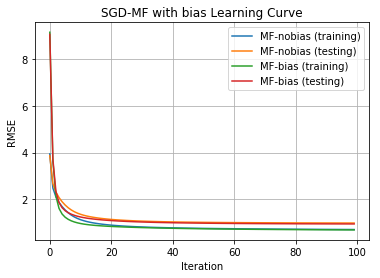

In [22]:
plt.plot(range(100), train_errors_list, linestyle='-', label='MF-nobias (training)')
plt.plot(range(100), test_errors_list, linestyle='-', label='MF-nobias (testing)')
plt.plot(range(100), train_errors_sgd_bias, linestyle='-',  label='MF-bias (training)')
plt.plot(range(100), test_errors_sgd_bias, linestyle='-', label='MF-bias (testing)')
plt.title('SGD-MF with bias Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [27]:
factor_k=list(range(10,101,10))
train_errors_k=[]
test_errors_k=[]
train_errors_bias_k=[]
test_errors_bias_k=[]
for k in factor_k:
    sgd_p,sgd_q,train_errors_list,test_errors_list=Stochastic_Gradient_Descent(train_matrix,test_matrix,k,0.01,0.1,20)
    
    train_errors_k.append(train_errors_list[-1])
    test_errors_k.append(test_errors_list[-1])
    
    sgd_p,sgd_q,train_errors_sgd_bias,test_errors_sgd_bias=Stochastic_Gradient_Descent_with_Bias(train_matrix,test_matrix,k,0.01,0.1,20)
    
    train_errors_bias_k.append(train_errors_sgd_bias[-1])
    test_errors_bias_k.append(test_errors_sgd_bias[-1])

Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iterati

d:\applications\python\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
d:\applications\python\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app


SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
Computing using SGD ......
SGD Iteration 1


d:\applications\python\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
d:\applications\python\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply


SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD Iteration 19
SGD Iteration 20
Computing using SGD ......
SGD Iteration 1
SGD Iteration 2
SGD Iteration 3
SGD Iteration 4
SGD Iteration 5
SGD Iteration 6
SGD Iteration 7
SGD Iteration 8
SGD Iteration 9
SGD Iteration 10
SGD Iteration 11
SGD Iteration 12
SGD Iteration 13
SGD Iteration 14
SGD Iteration 15
SGD Iteration 16
SGD Iteration 17
SGD Iteration 18
SGD

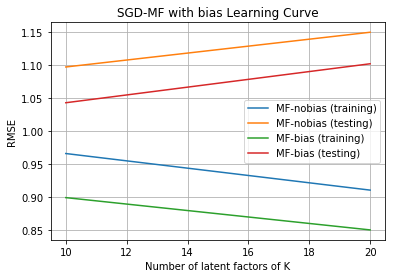

In [28]:
plt.plot(factor_k, train_errors_k, linestyle='-', label='MF-nobias (training)')
plt.plot(factor_k, test_errors_k, linestyle='-', label='MF-nobias (testing)')
plt.plot(factor_k, train_errors_bias_k, linestyle='-',  label='MF-bias (training)')
plt.plot(factor_k, test_errors_bias_k, linestyle='-', label='MF-bias (testing)')
plt.title('SGD-MF with bias Learning Curve')
plt.xlabel('Number of latent factors of K')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()